In [3]:
import sys

ACCESSORY_DIR = "/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks/EP Pair Evaluation/accessary_files"
sys.path.insert(0, ACCESSORY_DIR)

from bio_foundation_model_loader import dnalm_embedding_extraction
from ep_pair_identification import EP_pair_identification_cv, plot_distance_stratified_metrics, plot_precision_recall_curves, paired_swap_test

import pickle
import pandas as pd
import torch

In [ ]:
embedding_extractor_hyenaDNA = dnalm_embedding_extraction(model_class="HyenaDNA", model_name="hyenadna-large-1m-seqlen-hf", device=torch.device("cuda"))
embedding_extractor_mistral = dnalm_embedding_extraction(model_class="Mistral", model_name="Mistral-DNA-v1-422M-hg38", device=torch.device("cuda"))
embedding_extractor_dnabert2 = dnalm_embedding_extraction(model_class="DNABERT2", model_name="DNABERT-2-117M", device=torch.device("cuda"))
embedding_extractor_nt = dnalm_embedding_extraction(model_class="Nucleotide Transformer", model_name="nucleotide-transformer-v2-500m-multi-species", device=torch.device("cuda"))
# embedding_extractor_caduceus = dnalm_embedding_extraction(model_class="Caduceus", model_name="caduceus-ps_seqlen-131k_d_model-256_n_layer-16", device=torch.device("cuda"))
embedding_extractor_genalm = dnalm_embedding_extraction(model_class="GENA-LM", model_name="gena-lm-bert-large-t2t", device=torch.device("cuda"))

In [4]:
df = pd.read_csv("/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks/EP Pair Evaluation/accessary_files/EPCrisprBenchmark_ensemble_data_GRCh38.K562_AllFeatures_NAfilled.FullModel.tsv", sep="\\t")
df["distanceToTSS_abs"] = df["distanceToTSS"].abs()
df["enhancer_length"] = df["chromEnd"] - df["chromStart"]

/tmp/ipython-input-410667867.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("/content/drive/MyDrive/GitHub/Biological-Foundation-Model/Notebooks/EP Pair Evaluation/accessary_files/EPCrisprBenchmark_ensemble_data_GRCh38.K562_AllFeatures_NAfilled.FullModel.tsv", sep="\\t")


In [7]:
feature_sets = {
    "Model: Distance only": ["distanceToTSS_abs"],
    "Model: Embedding only": ["embeddings"],
    "Model: Embedding + Distance": ["distanceToTSS_abs", "embeddings"],
    "Model: + enhancer length": ["distanceToTSS_abs", "embeddings", "enhancer_length"],

    "Model: + Chromatin features": [
        "distanceToTSS_abs",
        "embeddings",
        "normalizedH3K27ac_enh",
        "normalizedH3K27ac_prom",
        "H3K27ac_e_grad_max_L_8",
        "H3K27ac_e_grad_min_L_8",
        "H3K27ac_p_grad_max_L_8",
        "H3K27ac_p_grad_min_L_8",
        "promCTCF",
        "enhCTCF",
    ],

    "Model: + DNase": [
        "distanceToTSS_abs",
        "embeddings",
        "normalizedDNase_enh",
        "normalizedDNase_prom",
        "DNase_e_grad_max_L_8",
        "DNase_e_grad_min_L_8",
        "DNase_p_grad_max_L_8",
        "DNase_p_grad_min_L_8",
    ],

    "Model: + Hi-C / 3D": [
        "distanceToTSS_abs",
        "embeddings",
        "3DContact",
        "3DContact_squared",
        "HiCLoopOutsideNormalized",
        "HiCLoopCrossNormalized",
        "PEToutsideNormalized",
        "PETcrossNormalized",
        "inTAD",
        "inCCD",
    ],

    "Model: + H3K4me3 (promoter mark)": [
        "distanceToTSS_abs",
        "embeddings",
        "H3K4me3_e_max_L_8",
        "H3K4me3_e_grad_max_L_8",
        "H3K4me3_e_grad_min_L_8",
        "H3K4me3_p_max_L_8",
        "H3K4me3_p_grad_max_L_8",
        "H3K4me3_p_grad_min_L_8",
    ],

    "Model: + EP300": [
        "distanceToTSS_abs",
        "embeddings",
        "normalizedEP300_enhActivity",
    ],

    # "Model: + Conservation": [
    #     "distanceToTSS_abs",
    #     "embeddings",
    #     "phastConMax",
    #     "phyloPMax",
    # ],

    # "Model: + ABC features": [
    #     "distanceToTSS_abs",
    #     "embeddings",
    #     "activity_enh",
    #     "activity_enh_squared",
    #     "activity_prom",
    #     "ABCNumerator",
    #     "ABCDenominator",
    #     "ABCScore",
    # ],

    "Model: + Local context": [
        "distanceToTSS_abs",
        "embeddings",
        "numNearbyEnhancers",
        "sumNearbyEnhancers",
        "numTSSEnhGene",
    ],

    "Model: + Correlation (co-activity)": [
        "distanceToTSS_abs",
        "embeddings",
        "averageCorrWeighted",
    ],

    "Model: + Promoter/Gene annotation": [
        "distanceToTSS_abs",
        "embeddings",
        "P2PromoterClass",
        "ubiquitousExpressedGene",
    ],

    # Your original all-in model (kept), plus the new modalities added
    "Model: + all (extended)": [
        "distanceToTSS_abs",
        "embeddings",
        "enhancer_length",

        # Hi-C / 3D
        "3DContact",
        "3DContact_squared",
        "HiCLoopOutsideNormalized",
        "HiCLoopCrossNormalized",
        "PEToutsideNormalized",
        "PETcrossNormalized",
        "inTAD",
        "inCCD",

        # DNase
        "normalizedDNase_enh",
        "normalizedDNase_prom",
        "DNase_e_grad_max_L_8",
        "DNase_e_grad_min_L_8",
        "DNase_p_grad_max_L_8",
        "DNase_p_grad_min_L_8",

        # H3K27ac + CTCF
        "normalizedH3K27ac_enh",
        "normalizedH3K27ac_prom",
        "H3K27ac_e_grad_max_L_8",
        "H3K27ac_e_grad_min_L_8",
        "H3K27ac_p_grad_max_L_8",
        "H3K27ac_p_grad_min_L_8",
        "promCTCF",
        "enhCTCF",

        # H3K4me3
        "H3K4me3_e_max_L_8",
        "H3K4me3_e_grad_max_L_8",
        "H3K4me3_e_grad_min_L_8",
        "H3K4me3_p_max_L_8",
        "H3K4me3_p_grad_max_L_8",
        "H3K4me3_p_grad_min_L_8",

        # EP300
        "normalizedEP300_enhActivity",

        # # Conservation
        # "phastConMax",
        # "phyloPMax",

        # # ABC engineered
        # "activity_enh",
        # "activity_enh_squared",
        # "activity_prom",
        # "ABCNumerator",
        # "ABCDenominator",
        # "ABCScore",

        # Local context
        "numNearbyEnhancers",
        "sumNearbyEnhancers",
        "numTSSEnhGene",

        # Correlation
        "averageCorrWeighted",

        # Annotation
        "P2PromoterClass",
        "ubiquitousExpressedGene",
    ],
}


HyenaDNA


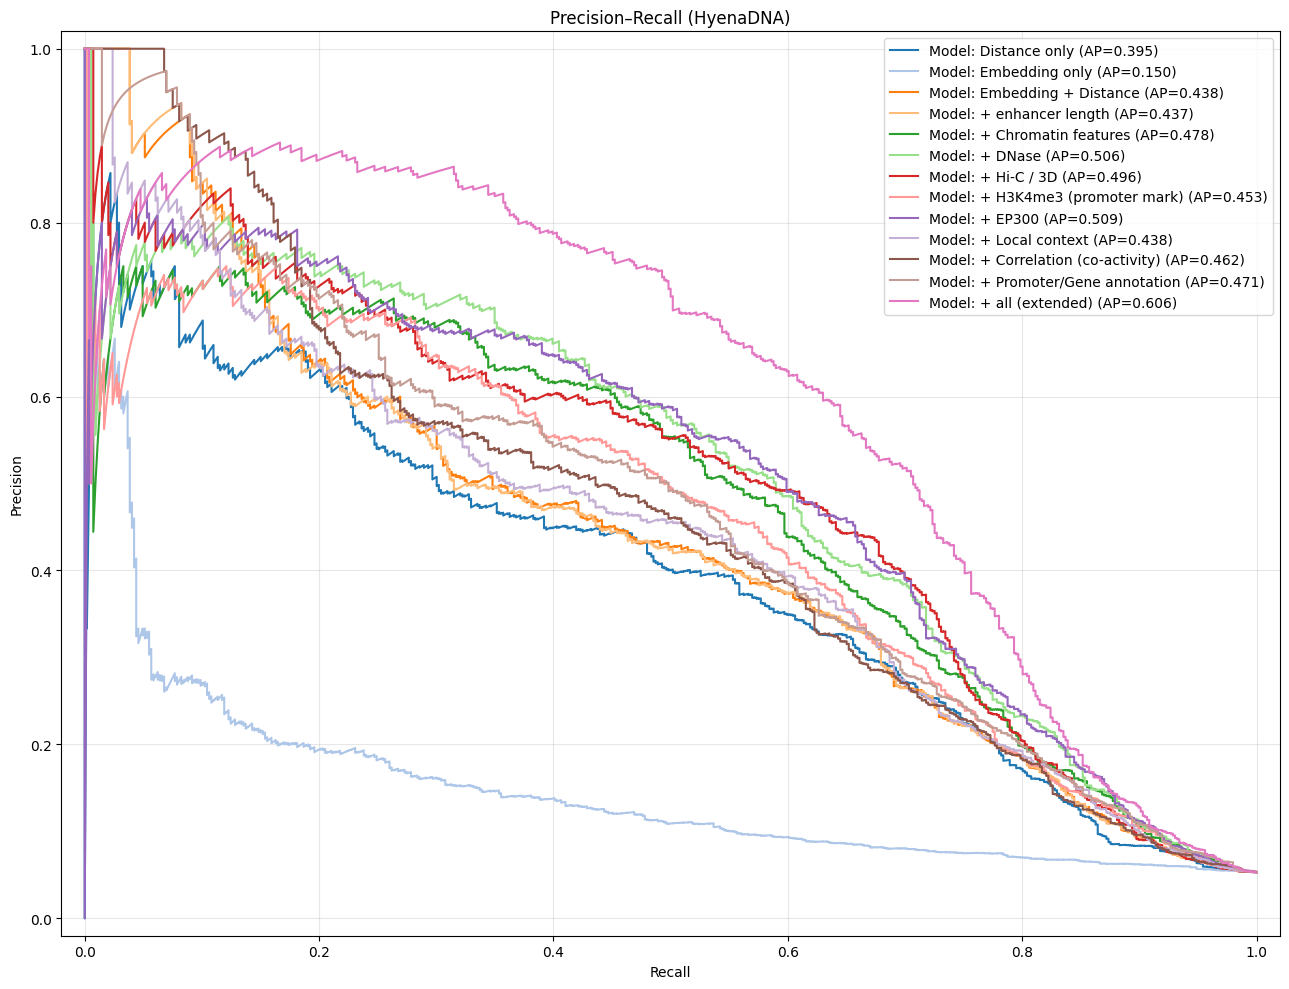


=== Model: Embedding + Distance vs Model: + enhancer length ===
{'delta_obs': 0.00026425959328509643, 'p_value': 0.023629763702362975, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + enhancer length')}

=== Model: Embedding + Distance vs Model: + Chromatin features ===
{'delta_obs': 0.03604783019904926, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Chromatin features')}

=== Model: Embedding + Distance vs Model: + DNase ===
{'delta_obs': 0.04756886955493352, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + DNase')}

=== Model: Embedding + Distance vs Model: + Hi-C / 3D ===
{'delta_obs': 0.0489244659052536, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Hi-C / 3D')}

=== Model: Embedding + Distance vs Model: + H3K4me3 (promoter mark) ===
{'d

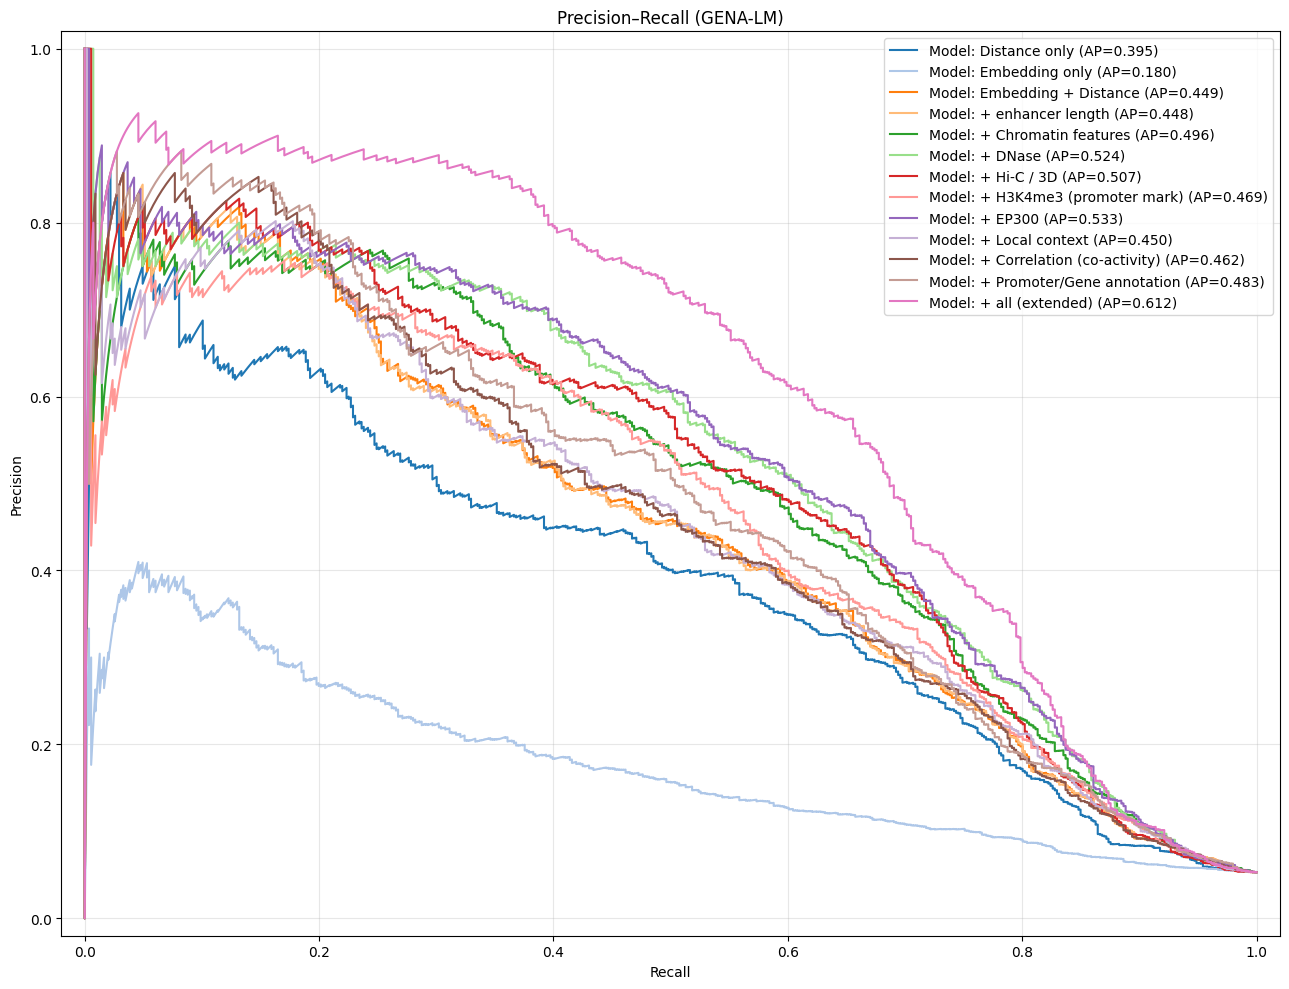


=== Model: Embedding + Distance vs Model: + enhancer length ===
{'delta_obs': 0.00017978941764297716, 'p_value': 0.06509934900650993, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + enhancer length')}

=== Model: Embedding + Distance vs Model: + Chromatin features ===
{'delta_obs': 0.031958811788771316, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Chromatin features')}

=== Model: Embedding + Distance vs Model: + DNase ===
{'delta_obs': 0.04422583348964336, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + DNase')}

=== Model: Embedding + Distance vs Model: + Hi-C / 3D ===
{'delta_obs': 0.04023613519097997, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Hi-C / 3D')}

=== Model: Embedding + Distance vs Model: + H3K4me3 (promoter mark) ===
{'

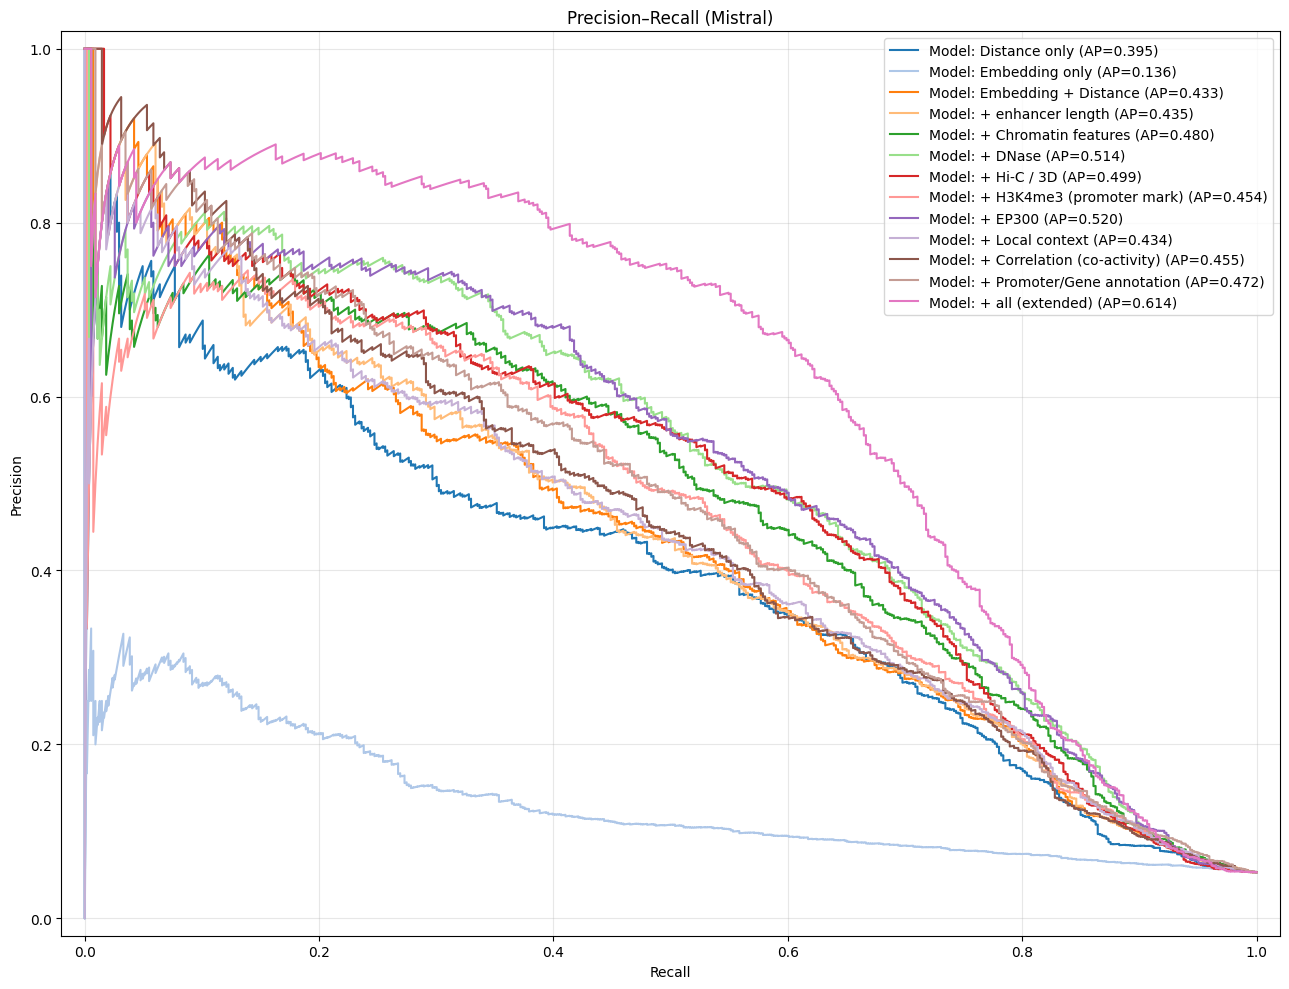


=== Model: Embedding + Distance vs Model: + enhancer length ===
{'delta_obs': 0.001009564365877646, 'p_value': 0.03130968690313097, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + enhancer length')}

=== Model: Embedding + Distance vs Model: + Chromatin features ===
{'delta_obs': 0.03666566491013407, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Chromatin features')}

=== Model: Embedding + Distance vs Model: + DNase ===
{'delta_obs': 0.049752395779559984, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + DNase')}

=== Model: Embedding + Distance vs Model: + Hi-C / 3D ===
{'delta_obs': 0.04576169579146204, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Hi-C / 3D')}

=== Model: Embedding + Distance vs Model: + H3K4me3 (promoter mark) ===
{'de

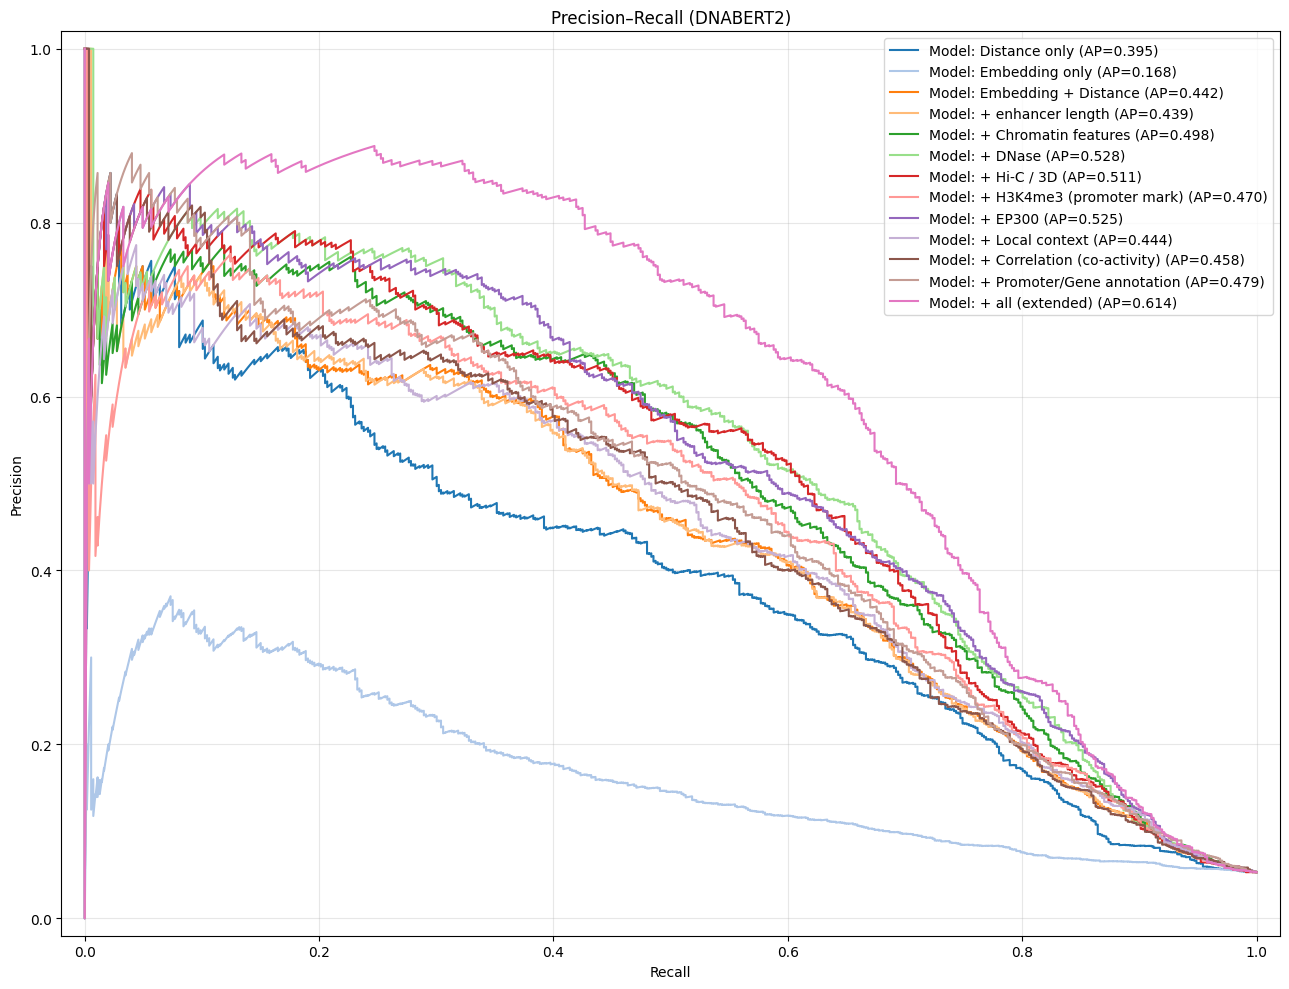


=== Model: Embedding + Distance vs Model: + enhancer length ===
{'delta_obs': 2.713038780226524e-06, 'p_value': 0.987410125898741, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + enhancer length')}

=== Model: Embedding + Distance vs Model: + Chromatin features ===
{'delta_obs': 0.032723718120278376, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Chromatin features')}

=== Model: Embedding + Distance vs Model: + DNase ===
{'delta_obs': 0.04474699749126213, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + DNase')}

=== Model: Embedding + Distance vs Model: + Hi-C / 3D ===
{'delta_obs': 0.042531078996780616, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Hi-C / 3D')}

=== Model: Embedding + Distance vs Model: + H3K4me3 (promoter mark) ===
{'de

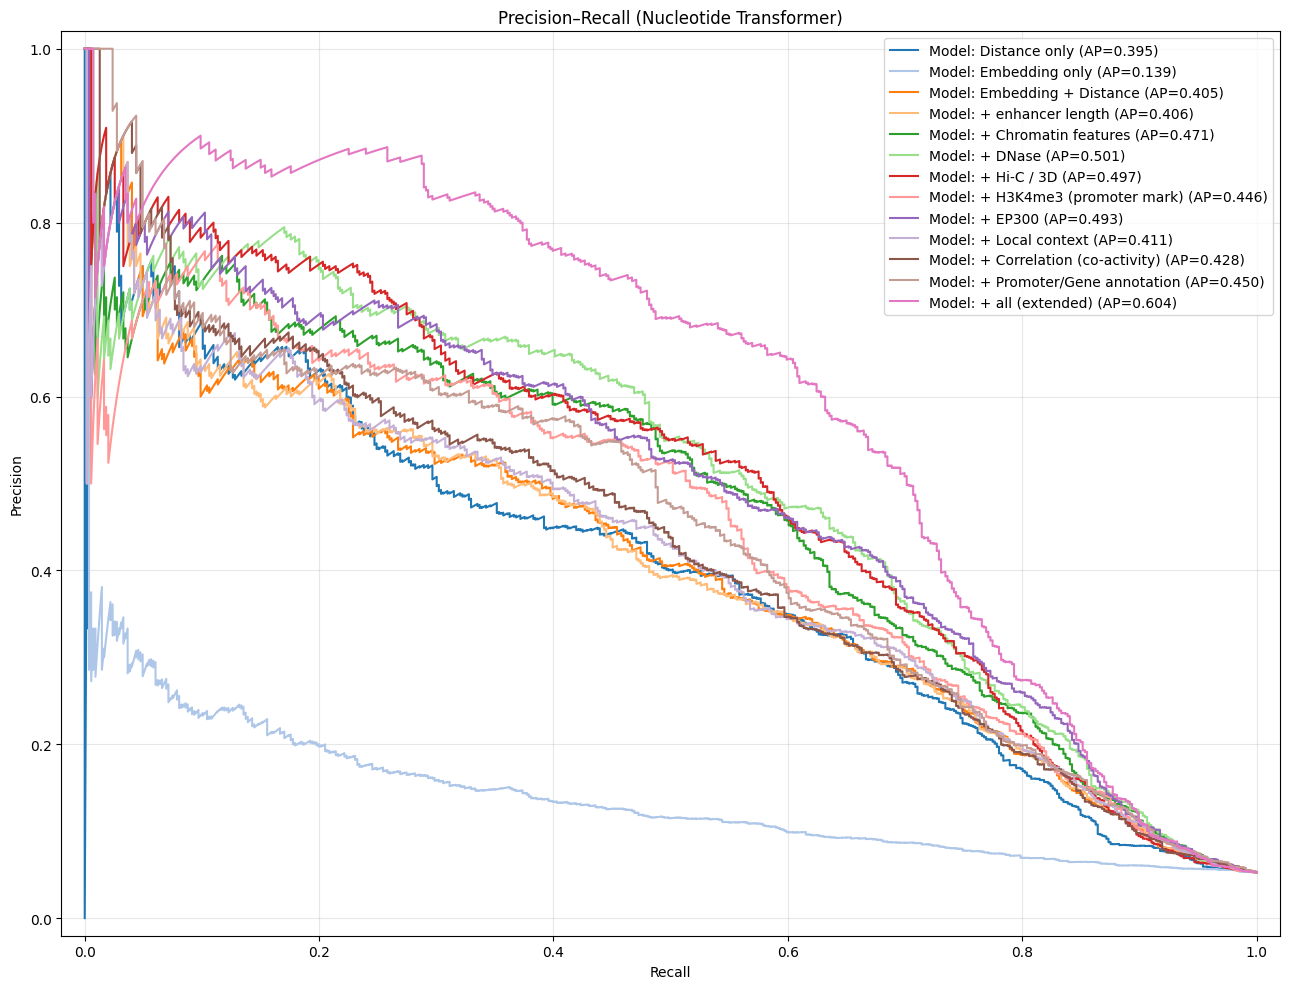


=== Model: Embedding + Distance vs Model: + enhancer length ===
{'delta_obs': 0.0006905587516456665, 'p_value': 0.05597944020559795, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + enhancer length')}

=== Model: Embedding + Distance vs Model: + Chromatin features ===
{'delta_obs': 0.0333991021110181, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Chromatin features')}

=== Model: Embedding + Distance vs Model: + DNase ===
{'delta_obs': 0.04523432019635175, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + DNase')}

=== Model: Embedding + Distance vs Model: + Hi-C / 3D ===
{'delta_obs': 0.043453357723141496, 'p_value': 9.99990000099999e-06, 'n': 10275, 'metric': 'logloss', 'labels': ('Model: Embedding + Distance', 'Model: + Hi-C / 3D')}

=== Model: Embedding + Distance vs Model: + H3K4me3 (promoter mark) ===
{'de

In [8]:
for model_class in ["HyenaDNA", "GENA-LM", "Mistral", "DNABERT2", "Nucleotide Transformer"]:

    pickle_path = (
            "/content/drive/MyDrive/GitHub/Biological-Foundation-Model/"
            "Notebooks/EP Pair Evaluation/accessary_files/"
            f"df_{model_class}.pkl"
        )

    with open(pickle_path, "rb") as f:
        df_emb = pickle.load(f)

    keys = ["chrom", "chromStart", "chromEnd", "chrTSS", "startTSS", "endTSS"]
    cols_to_add = ["enhancer_embedding_mean", "promoter_embedding_mean"]
    df_emb_small = df_emb[keys + cols_to_add].copy()
    df_emb_small_dedup = df_emb_small.drop_duplicates(subset=keys, keep="first")
    df2 = df.merge(df_emb_small_dedup, on=keys, how="inner", validate="m:1")

    print(model_class)

    results = EP_pair_identification_cv(
        df2,
        feature_sets,
        distance_col="distanceToTSS_abs",
        n_splits=5,
        pca_components=50,
        random_state=0,
    )

    plot_precision_recall_curves(results, title=f"Precision–Recall ({model_class})")

    # plot_distance_stratified_metrics(
    #     df2,
    #     results,
    #     model_class,
    #     distance_col="distanceToTSS_abs",
    #     n_bins=10,
    #     metrics=("f1", "precision", "recall", "accuracy"),
    #     use_proba_threshold=0.5,
    # )

    labels = list(feature_sets.keys())
    for label1 in labels[3:]:  # skip first three keys
        res = paired_swap_test(
            results,
            label0="Model: Embedding + Distance",
            label1=label1,
            metric="logloss",
            B=100000,
            seed=42,
            two_sided=True,
        )
        print(f"\n=== Model: Embedding + Distance vs {label1} ===")
        print(res)